Reading small sample for feature discovery / quick stats...
Processing full train CSV in chunks and building feature matrix (this may take time)...
 - processed train chunk 1, cumulative rows: 500000
 - processed train chunk 2, cumulative rows: 1000000
 - processed train chunk 3, cumulative rows: 1500000
 - processed train chunk 4, cumulative rows: 2000000
 - processed train chunk 5, cumulative rows: 2500000
 - processed train chunk 6, cumulative rows: 3000000
 - processed train chunk 7, cumulative rows: 3500000
 - processed train chunk 8, cumulative rows: 4000000
 - processed train chunk 9, cumulative rows: 4500000
 - processed train chunk 10, cumulative rows: 5000000
 - processed train chunk 11, cumulative rows: 5114514
Total train rows (features): 5114514
Processing test CSV in chunks and building feature matrix...
 - processed test chunk 1, cumulative rows: 500000
 - processed test chunk 2, cumulative rows: 1000000
 - processed test chunk 3, cumulative rows: 1500000
 - processed te

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_incremental_pca.py:364: RuntimeWarning: overflow encountered in square
  explained_variance = S**2 / (n_total_samples - 1)
C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_incremental_pca.py:365: RuntimeWarning: overflow encountered in square
  explained_variance_ratio = S**2 / np.sum(col_var * n_total_samples)


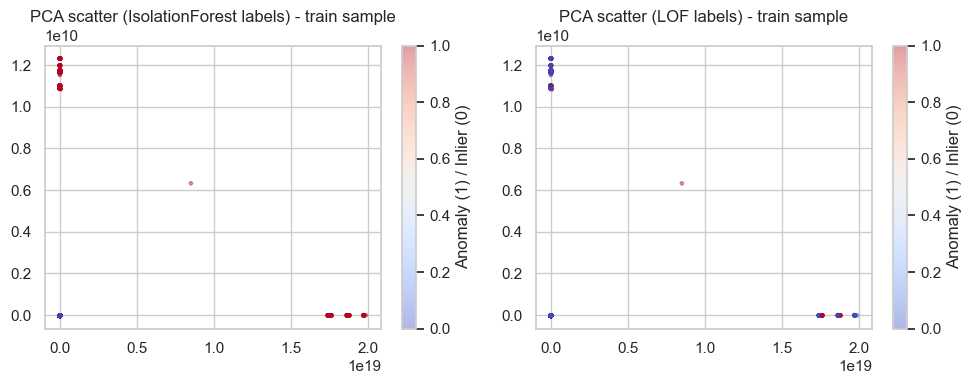

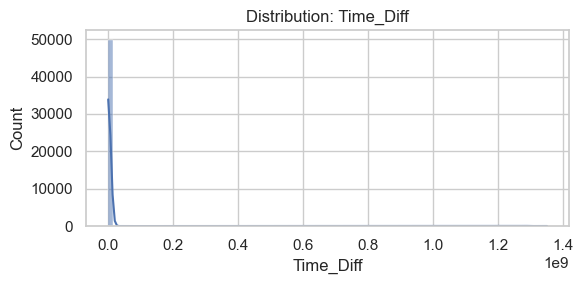

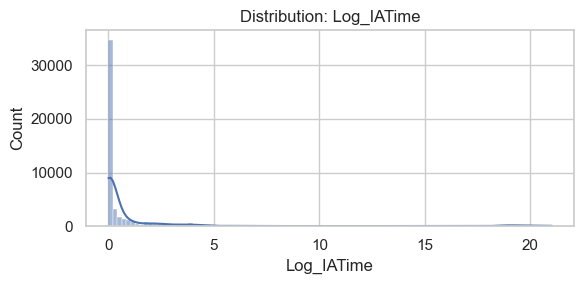

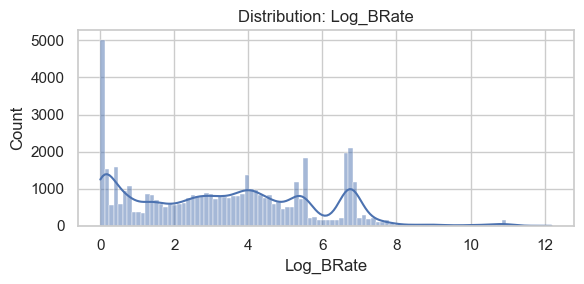

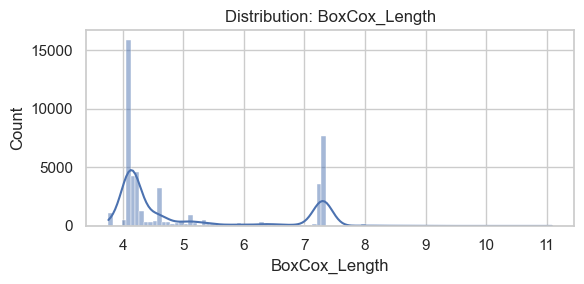

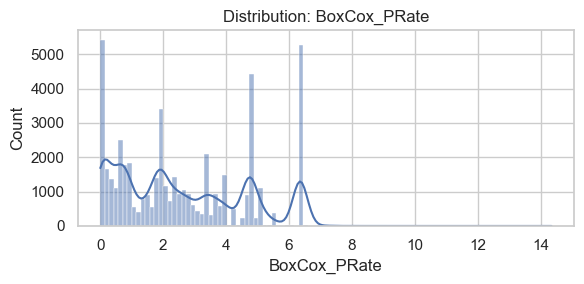

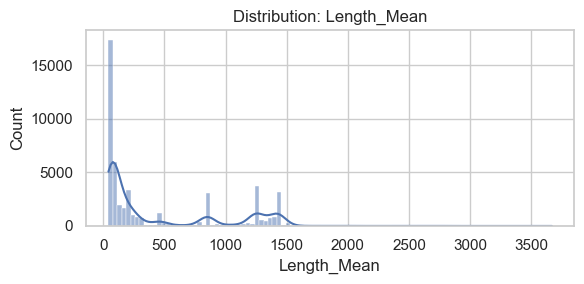

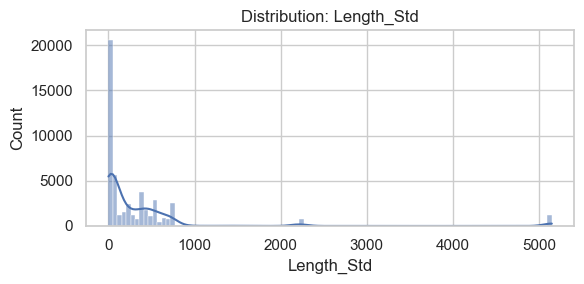

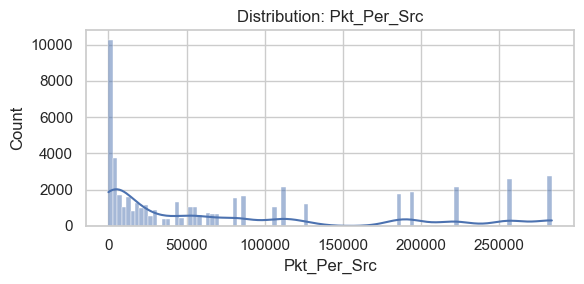

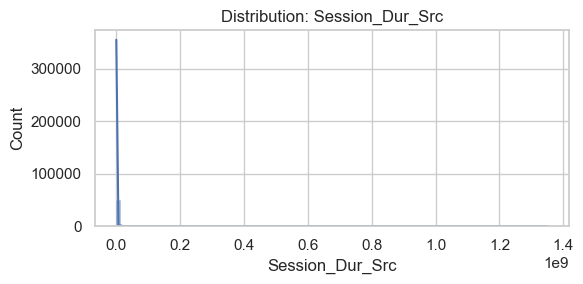

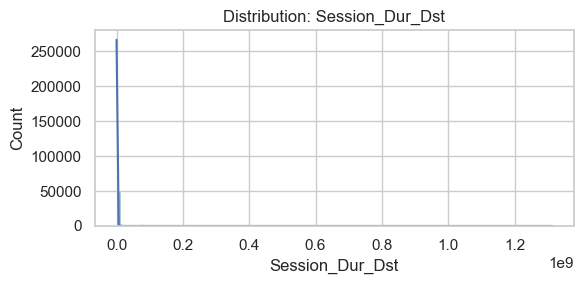

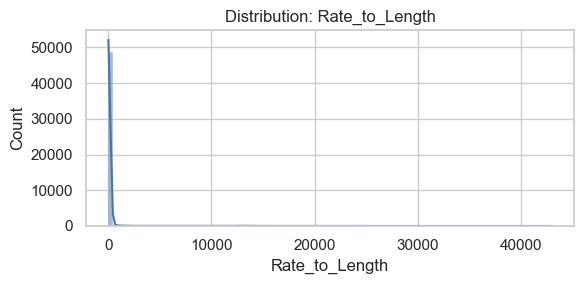

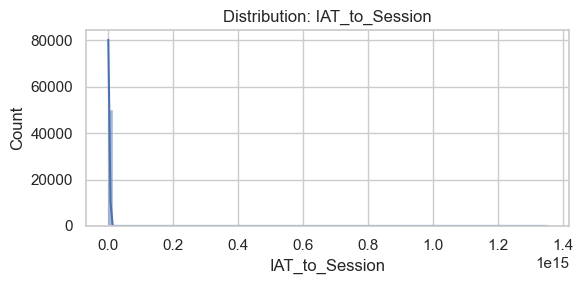

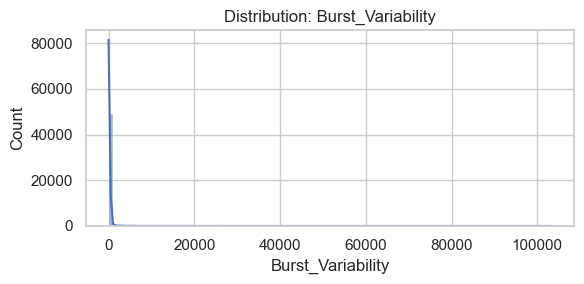

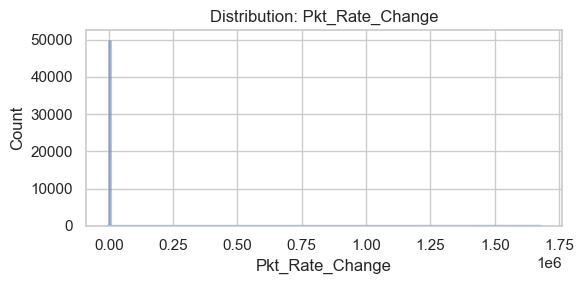

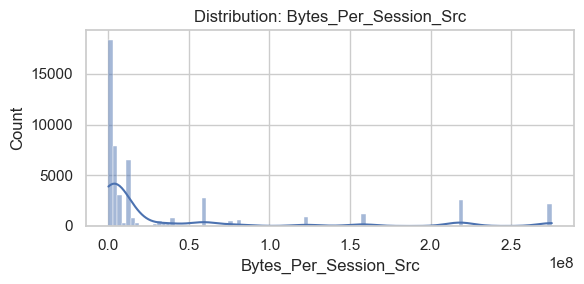

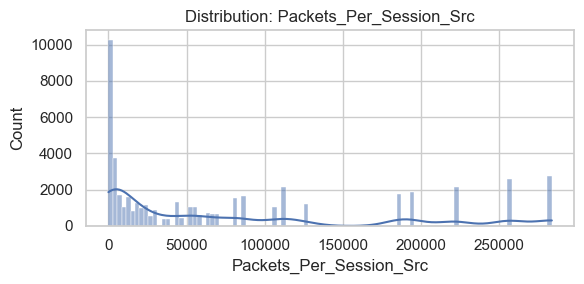

Summary saved to unsupervised_summary.json
Total pipeline time: 45.15 minutes


In [1]:
import os
import time
import json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import davies_bouldin_score, classification_report
from sklearn.utils import resample

sns.set(style="whitegrid")

# -------------------------
# CONFIG
# -------------------------
TRAIN_PATH = r'X:\Dissertacao\python_projects\dataset\ISCX-Bot-2014\ISCX_csv\Testing_file.csv'
TEST_PATH = r'X:\Dissertacao\python_projects\dataset\ISCX-Bot-2014\ISCX_csv\Training_file.csv'

CHUNKSIZE = 500_000                # rows to read per chunk
SAMPLE_FOR_QUICK = 100_000         # small sample for quick plotting / silhouette
SAMPLE_FOR_LOF_FIT = 200_000       # max rows to fit LOF (LOF expensive)
PCA_BATCH = 100_000                # batch size for IncrementalPCA partial_fit
SILHOUETTE_SAMPLE = 10_000         # silhouette sample size
RANDOM_STATE = 42

# IsolationForest config (tweakable)
IF_N_ESTIMATORS = 300
IF_MAX_SAMPLES = "auto"            # or integer <= n_samples, or float fraction
IF_CONTAMINATION = "auto"

# LOF config (we fit on a sample to limit memory/time)
LOF_N_NEIGHBORS = 25
ALGORITHM = "kd_tree" # ball_tree
LOF_METRIC = "chebyshev" #euclidean / manhattan
LOF_CONTAMINATION = "auto"


OUTPUT_SUMMARY = "unsupervised_summary.json"

# -------------------------
# HELPERS
# -------------------------
def read_csv_in_chunks(path, chunksize=CHUNKSIZE, usecols=None):
    """Yield dataframe chunks from CSV."""
    it = pd.read_csv(path, low_memory=False, chunksize=chunksize, usecols=usecols, encoding='ISO-8859-1')
    for chunk in it:
        yield chunk

def downcast_df(df):
    """Downcast numeric dtypes to save memory (float32 / int32)"""
    for col in df.select_dtypes(include=["float64"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="float")
    for col in df.select_dtypes(include=["int64"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")
    return df

def safe_concat(chunks):
    """Concatenate a list of small chunks into a single df (caller must be mindful of memory)."""
    if not chunks:
        return pd.DataFrame()
    return pd.concat(chunks, axis=0, ignore_index=True)

def safe_boxcox(series):
    arr = np.asarray(series.fillna(0.0).astype(float) + 1e-6)
    try:
        out, _ = boxcox(arr + 1e-6)
        return out
    except Exception:
        return np.log1p(arr)
# -------------------------
# FEATURE ENGINEERING (vectorized)
# -------------------------
def build_features_vectorized(df):
    
    df = df.copy()
    src = 'Source_enc' if 'Source_enc' in df.columns else 'Source'
    dst = 'Destination_enc' if 'Destination_enc' in df.columns else 'Destination'
    if 'Time' in df.columns:
        df['Time'] = pd.to_numeric(df['Time'], errors='coerce').fillna(0.0)
        df['Time_Diff'] = df.groupby(src)['Time'].diff().fillna(df.groupby(src)['Time'].transform('median')).fillna(0.0)
    else:
        df['Time_Diff'] = 0.0
    def pkt_rate_series(s):
        a = s.dropna().values
        if a.size < 2:
            return pd.Series(np.zeros(len(s)), index=s.index)
        q1, q3 = np.percentile(a, [25,75])
        iqr = max(q3 - q1, 1e-9)
        cl = np.clip(a, q1 - 1.5*iqr, q3 + 1.5*iqr)
        denom = cl.max() - cl.min()
        if denom <= 1e-6:
            rate = np.zeros_like(a)
        else:
            rate = np.full_like(a, cl.size / denom, dtype=float)
        out = pd.Series(rate, index=s.dropna().index)
        return out.reindex(s.index).fillna(0.0)
    if 'Time' in df.columns:
        df['Packet_Rate'] = df.groupby(src)['Time'].transform(lambda s: pkt_rate_series(s)).fillna(0.0)
    else:
        df['Packet_Rate'] = 0.0
    df['Inter_Arrival_Time'] = df.groupby(src)['Time_Diff'].transform(lambda s: s.rolling(10, min_periods=1).mean()).fillna(0.0).clip(lower=1e-6)
    df['Burst_Rate'] = np.where(df['Inter_Arrival_Time']>1e-6, 1.0/df['Inter_Arrival_Time'], 0.0)
    df['Length'] = pd.to_numeric(df.get('Length', 0)).fillna(0)
    df['Length_Mean'] = df.groupby(src)['Length'].transform('mean').fillna(df['Length'].mean() if 'Length' in df.columns else 0.0)
    df['Length_Std']  = df.groupby(src)['Length'].transform('std').fillna(0.0)
    df['Pkt_Per_Src'] = df.groupby(src)['Length'].transform('count').fillna(0).astype(int)
    if 'Time' in df.columns:
        df['Session_Dur_Src'] = df.groupby(src)['Time'].transform(lambda x: x.max() - x.min()).fillna(0.0)
        df['Session_Dur_Dst'] = df.groupby(dst)['Time'].transform(lambda x: x.max() - x.min()).fillna(0.0)
    else:
        df['Session_Dur_Src'] = 0.0
        df['Session_Dur_Dst'] = 0.0
    df['Bytes_Per_Session_Src'] = df.groupby(src)['Length'].transform('sum').fillna(0.0)
    df['Bytes_Per_Session_Dst'] = df.groupby(dst)['Length'].transform('sum').fillna(0.0)
    df['Packets_Per_Session_Src'] = df['Pkt_Per_Src']
    df['Packets_Per_Session_Dst'] = df.groupby(dst)['Length'].transform('count').fillna(0).astype(int)
    df['Log_IATime'] = np.log1p(df['Inter_Arrival_Time'])
    df['Log_BRate']  = np.log1p(df['Burst_Rate'].clip(lower=0))
    df['BoxCox_Length'] = safe_boxcox(df['Length']) if 'Length' in df.columns else np.zeros(len(df))
    df['BoxCox_PRate']  = safe_boxcox(df['Packet_Rate'])
    df['Rate_to_Length'] = df['Burst_Rate'] / (df['BoxCox_Length'] + 1e-6)
    df['IAT_to_Session'] = df['Inter_Arrival_Time'] / (df['Session_Dur_Src'] + 1e-6)
    df['Burst_Variability'] = df['Burst_Rate'].rolling(5, min_periods=1).std().fillna(0.0).values
    df['Pkt_Rate_Change']  = df['Packet_Rate'].diff().fillna(0.0).values
    
    features = ['Time_Diff','Log_IATime','Log_BRate',
                'BoxCox_Length','BoxCox_PRate','Length_Mean',
                'Length_Std','Pkt_Per_Src','Session_Dur_Src',
                'Session_Dur_Dst','Rate_to_Length','IAT_to_Session',
                'Burst_Variability','Pkt_Rate_Change',
                'Bytes_Per_Session_Src','Packets_Per_Session_Src']

    # Make sure each feature exists
    for f in features:
        if f not in df.columns:
            df[f] = 0.0

    # Downcast to save memory
    df = downcast_df(df)

    return df, features

# -------------------------
# UTILITY: batched predict
# -------------------------
def batched_predict(model, X_df, batch_size=100_000):
    """Predict in batches (works for models with predict supporting numpy arrays)."""
    n = len(X_df)
    preds = np.empty(n, dtype=object)
    scores = None
    # Some models provide predict_proba; we can try to capture it
    has_proba = hasattr(model, "predict_proba")
    if has_proba:
        scores = np.zeros((n, len(model.classes_)))
    for i in range(0, n, batch_size):
        j = min(i + batch_size, n)
        Xb = X_df.iloc[i:j].values
        preds[i:j] = model.predict(Xb)
        if has_proba:
            scores[i:j, :] = model.predict_proba(Xb)
    return preds, scores

def batched_lof_predict(lof_model, X_df, batch_size=100_000):
    """LOF novelty predict in batches. LOF.predict returns 1 for inlier, -1 for outlier."""
    n = len(X_df)
    preds = np.zeros(n, dtype=int)
    for i in range(0, n, batch_size):
        j = min(i + batch_size, n)
        Xb = X_df.iloc[i:j].values
        preds[i:j] = lof_model.predict(Xb)
    return preds

# -------------------------
# MAIN PIPELINE
# -------------------------
def main():
    t0_all = time.time()

    # STEP 1: Read small sample (for feature set discovery & quick plots)
    print("Reading small sample for feature discovery / quick stats...")
    sample_chunks = []
    sample_rows = 0
    for chunk in read_csv_in_chunks(TRAIN_PATH, chunksize=CHUNKSIZE):
        sample_chunks.append(chunk)
        sample_rows += len(chunk)
        if sample_rows >= SAMPLE_FOR_QUICK:
            break
    if len(sample_chunks) == 0:
        raise RuntimeError("No data found in TRAIN_PATH.")
    sample_df = safe_concat(sample_chunks).reset_index(drop=True)
    sample_df, discovered_features = build_features_vectorized(sample_df)
    #print("Discovered features:", discovered_features)

    # STEP 2: Load entire TRAIN (chunked), compute features, and collect (optionally sample)
    print("Processing full train CSV in chunks and building feature matrix (this may take time)...")
    train_feature_frames = []
    n_train_rows = 0
    for idx, chunk in enumerate(read_csv_in_chunks(TRAIN_PATH, chunksize=CHUNKSIZE)):
        chunk, _ = build_features_vectorized(chunk)
        train_feature_frames.append(chunk[discovered_features])  # keep only feature columns
        n_train_rows += len(chunk)
        print(f" - processed train chunk {idx+1}, cumulative rows: {n_train_rows}")
    df_train_feats = safe_concat(train_feature_frames)
    print(f"Total train rows (features): {len(df_train_feats)}")

    # STEP 3: Load entire TEST similarly
    print("Processing test CSV in chunks and building feature matrix...")
    test_feature_frames = []
    n_test_rows = 0
    for idx, chunk in enumerate(read_csv_in_chunks(TEST_PATH, chunksize=CHUNKSIZE)):
        chunk, _ = build_features_vectorized(chunk)
        test_feature_frames.append(chunk[discovered_features])
        n_test_rows += len(chunk)
        print(f" - processed test chunk {idx+1}, cumulative rows: {n_test_rows}")
    df_test_feats = safe_concat(test_feature_frames)
    print(f"Total test rows (features): {len(df_test_feats)}")

    # Optionally free memory used by chunk lists
    train_feature_frames = None
    test_feature_frames = None

    # STEP 4: Scaling (RobustScaler fit on train)
    print("Fitting RobustScaler on train features...")
    scaler = RobustScaler()
    scaler.fit(df_train_feats.values)   # may be large but required once
    X_train_scaled = pd.DataFrame(scaler.transform(df_train_feats.values), columns=discovered_features)
    X_test_scaled  = pd.DataFrame(scaler.transform(df_test_feats.values), columns=discovered_features)
    # reduce dtype
    X_train_scaled = X_train_scaled.astype(np.float32)
    X_test_scaled  = X_test_scaled.astype(np.float32)

    # STEP 5: Isolation Forest training
    print("Training IsolationForest (may use subsampling internally)...")
    t0 = time.time()
    iso = IsolationForest(
        n_estimators=IF_N_ESTIMATORS,
        max_samples=IF_MAX_SAMPLES,
        contamination=IF_CONTAMINATION,
        random_state=RANDOM_STATE,
        verbose=0,  # 0 for cleaner logs
        n_jobs=-1
    )
    iso.fit(X_train_scaled.values)
    t1 = time.time()
    print(f"IsolationForest trained in {(t1-t0):.1f}s")

    # STEP 6: LOF fitting on a sample (LOF is costly) and then batched predict
    lof_sample_n = min(SAMPLE_FOR_LOF_FIT, len(X_train_scaled))
    if lof_sample_n < 1000:
        lof_sample_n = min(1000, len(X_train_scaled))
    print(f"Fitting LOF on a sample of {lof_sample_n} rows (LOF expensive to fit on full data).")
    # sample train rows for LOF fit (stratified not applicable; we just sample randomly)
    lof_fit_df = X_train_scaled.sample(n=lof_sample_n, random_state=RANDOM_STATE)
    lof = LocalOutlierFactor(
        n_neighbors=LOF_N_NEIGHBORS,
        metric=LOF_METRIC,
        algorithm=ALGORITHM,
        contamination=LOF_CONTAMINATION,
        novelty=True,   # allow predict on new data
        n_jobs=-1
    )
    t0 = time.time()
    lof.fit(lof_fit_df.values)   # fit on sample
    t1 = time.time()
    print(f"LOF (sample fit) trained in {(t1-t0):.1f}s")

    # STEP 7: Predictions (batched) for both models on train & test
    BATCH_PRED = 200_000
    print("Predicting IsolationForest on train (batched)...")
    iso_train_preds, iso_train_scores = batched_predict(iso, X_train_scaled, batch_size=BATCH_PRED)
    print("Predicting IsolationForest on test (batched)...")
    iso_test_preds, iso_test_scores = batched_predict(iso, X_test_scaled, batch_size=BATCH_PRED)

    print("Predicting LOF (novelty) on train (batched)...")
    lof_train_preds = batched_lof_predict(lof, X_train_scaled, batch_size=BATCH_PRED)
    print("Predicting LOF (novelty) on test (batched)...")
    lof_test_preds = batched_lof_predict(lof, X_test_scaled, batch_size=BATCH_PRED)

    # ISO/LOF mapping: for IsolationForest, predictions are {1: inlier, -1: outlier}
    # For convenience create boolean anomaly columns
    iso_train_anom = (iso_train_preds == -1)
    iso_test_anom  = (iso_test_preds == -1)
    lof_train_anom = (lof_train_preds == -1)
    lof_test_anom  = (lof_test_preds == -1)

    # Agreement
    train_agreement = np.mean(iso_train_anom == lof_train_anom) * 100.0
    test_agreement  = np.mean(iso_test_anom == lof_test_anom) * 100.0

    # Anomaly percentages
    iso_train_pct = iso_train_anom.mean() * 100.0
    iso_test_pct  = iso_test_anom.mean() * 100.0
    lof_train_pct = lof_train_anom.mean() * 100.0
    lof_test_pct  = lof_test_anom.mean() * 100.0

    print(f"IsolationForest train anomaly %: {iso_train_pct:.2f}")
    print(f"IsolationForest test anomaly %:  {iso_test_pct:.2f}")
    print(f"LOF train anomaly %: {lof_train_pct:.2f}")
    print(f"LOF test anomaly %:  {lof_test_pct:.2f}")
    print(f"Model agreement on train: {train_agreement:.2f}%")
    print(f"Model agreement on test:  {test_agreement:.2f}%")

    # STEP 8: Davies–Bouldin Index (on a downsampled set to save time)
    db_sample_n = min(SILHOUETTE_SAMPLE, len(X_train_scaled))
    db_idx = np.random.RandomState(RANDOM_STATE).choice(len(X_train_scaled), size=db_sample_n, replace=False)
    db_X = X_train_scaled.iloc[db_idx].values
    # For DB index we need labels: use IsolationForest anomaly labels
    labels_for_db = iso_train_anom[db_idx].astype(int)  # 0/1
    
    try:
        db_score_if = davies_bouldin_score(db_X, labels_for_db)
    except Exception:
        db_score_if = float("nan")
    print(f"Davies–Bouldin Index (sample, IsolationForest labels): {db_score_if:.4f}")


    # STEP 9: PCA visualization (IncrementalPCA for large sets)
    # We'll compute 2-component PCA for plotting — use incremental partial_fit in batches
    print("Computing IncrementalPCA (2 components) for visualization (train sample)...")
    ipca = IncrementalPCA(n_components=2)
    # Fit on samples (we can partial_fit on chunks)
    fit_iter = 0
    for i in range(0, len(X_train_scaled), PCA_BATCH):
        batch = X_train_scaled.iloc[i:i + PCA_BATCH].values
        ipca.partial_fit(batch)
        fit_iter += 1
    # Transform (sample for plotting)
    plot_sample_n = min(100_000, len(X_train_scaled))
    plot_idx = np.random.RandomState(RANDOM_STATE).choice(len(X_train_scaled), size=plot_sample_n, replace=False)
    plot_X = X_train_scaled.iloc[plot_idx].values
    plot_proj = ipca.transform(plot_X)

    # Prepare labels for plotting (0 normal / 1 anomaly)
    plot_iso_labels = iso_train_anom[plot_idx].astype(int)
    plot_lof_labels = lof_train_anom[plot_idx].astype(int)

    # Scatter plot for IsolationForest
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(plot_proj[:, 0], plot_proj[:, 1], c=plot_iso_labels, cmap="coolwarm", alpha=0.4, s=6)
    plt.title("PCA scatter (IsolationForest labels) - train sample")
    plt.colorbar(label="Anomaly (1) / Inlier (0)")

    # Scatter plot for LOF
    plt.subplot(1, 2, 2)
    plt.scatter(plot_proj[:, 0], plot_proj[:, 1], c=plot_lof_labels, cmap="coolwarm", alpha=0.4, s=6)
    plt.title("PCA scatter (LOF labels) - train sample")
    plt.colorbar(label="Anomaly (1) / Inlier (0)")
    plt.tight_layout()
    plt.show()

    # STEP 10: Feature distributions plots (histograms) for a small sample
    small_plot_df = df_train_feats.sample(n=min(50_000, len(df_train_feats)), random_state=RANDOM_STATE)
    for feat in discovered_features:
        plt.figure(figsize=(6, 3))
        sns.histplot(small_plot_df[feat].astype(float), bins=100, kde=True)
        plt.title(f"Distribution: {feat}")
        plt.tight_layout()
        plt.show()

    # STEP 11: Build summary and save
    summary = {
        "n_train_rows": len(X_train_scaled),
        "n_test_rows": len(X_test_scaled),
        "IsolationForest": {
            "train_anomaly_pct": float(iso_train_pct),
            "test_anomaly_pct": float(iso_test_pct)
        },
        "LOF": {
            "train_anomaly_pct": float(lof_train_pct),
            "test_anomaly_pct": float(lof_test_pct),
            "fit_sample_n": int(lof_sample_n)
        },
        "agreement": {
            "train_pct": float(train_agreement),
            "test_pct": float(test_agreement)
        },
        "db_index_IF": float(db_score_if),
        "features": discovered_features
    }
    with open(OUTPUT_SUMMARY, "w") as fh:
        json.dump(summary, fh, indent=2)
    print("Summary saved to", OUTPUT_SUMMARY)

    t_all = time.time()
    print(f"Total pipeline time: {(t_all - t0_all)/60.0:.2f} minutes")

if __name__ == "__main__":
    main()
